<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification3/Custom_CNN_HybridDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define dataset directory
DATASET_DIRECTORY = 'Refined_Hybrid_Dataset'

# Image size & batch size
image_size = (48, 48)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT  # Splitting training data
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data (80%)
train_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"  # 80% for training
)

# Load Validation Data (20%)
val_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"  # 20% for validation
)

# Load Test Data (Untouched)
test_data = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "test"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False  # Keep order unchanged for evaluation
)

# Print dataset details
print(f"Training samples: {train_data.samples}, Classes: {train_data.num_classes}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")

Found 38119 images belonging to 7 classes.
Found 9529 images belonging to 7 classes.
Found 13723 images belonging to 7 classes.
Training samples: 38119, Classes: 7
Validation samples: 9529
Test samples: 13723


In [3]:
def count_images_in_file(directory):
    counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            counts[subdir] = sum(1 for file in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, file)))

    df = pd.DataFrame(counts, index=['Counts'])
    return df

train_count = count_images_in_file('Refined_Hybrid_Dataset/train')
test_count = count_images_in_file('Refined_Hybrid_Dataset/test')

print(train_count)
print(test_count)

        angry  disgust  fear  happy  neutral   sad  surprise
Counts   7000     5648  7000   7000     7000  7000      7000
        angry  disgust  fear  happy  neutral   sad  surprise
Counts   1927      678  1935   3373     2492  2487       831


<Axes: >

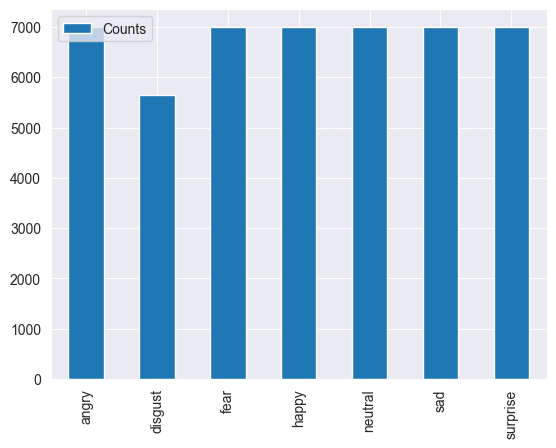

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

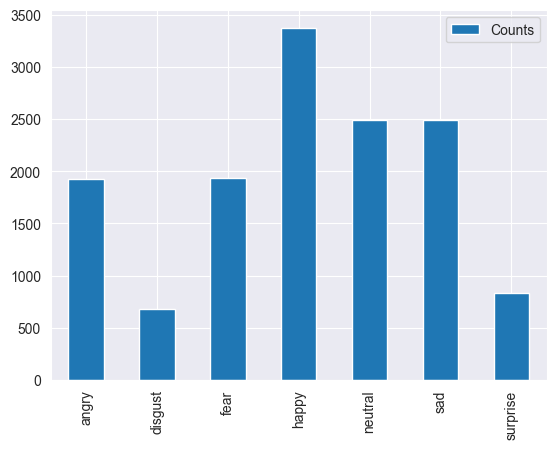

In [5]:
test_count.transpose().plot(kind='bar')

In [6]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),  # Added Dropout

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),  # Added Dropout
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),  # Reduced from 512
    BatchNormalization(),
    Dropout(0.4),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 512
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 256
    BatchNormalization(),
    Dropout(0.4),

    Dense(7, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,587,975 (6.06 MB)

 Trainable params: 1,585,799 (6.05 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [7]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=5,                # Allow 5 epochs of no improvement
    restore_best_weights=True, # Restore the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Monitor validation accuracy
    factor=0.5,                # Reduce the learning rate by half
    patience=3,                # Wait for 3 epochs of no improvement
    min_lr=1e-6,               # Lower bound for the learning rate
    verbose=1                  # Print a message when the learning rate is reduced
)

checkpoint = ModelCheckpoint(
    'best_model.keras',           # File to save the best model
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the best model
    mode='max',                # Maximize val_accuracy
    verbose=1
)

In [8]:
# Get the class labels assigned to each image in the training dataset
y_train = train_data.classes  # Extract labels from train_data

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format required by Keras
class_weights = dict(enumerate(class_weights))

In [9]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,  # Using validation data
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.1691 - loss: 8.8577
Epoch 1: val_accuracy improved from -inf to 0.14755, saving model to best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 423s 705ms/step - accuracy: 0.1691 - loss: 8.8570 - val_accuracy: 0.1475 - val_loss: 10.2023 - learning_rate: 1.0000e-04
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1996 - loss: 7.5103
Epoch 2: val_accuracy improved from 0.14755 to 0.18103, saving model to best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 123s 207ms/step - accuracy: 0.1996 - loss: 7.5098 - val_accuracy: 0.1810 - val_loss: 7.5360 - learning_rate: 1.0000e-04
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2431 - loss: 6.3661
Epoch 3: val_accuracy improved from 0.18103 to 0.22930, saving model to best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 111s 186ms/step - accuracy: 0.2431 - loss: 6.3657 - val_accuracy: 0.2293 - val_loss: 6.0554 - learning_rate: 1.0000e-04
Epoch 4/50
596/596 ━━━━━

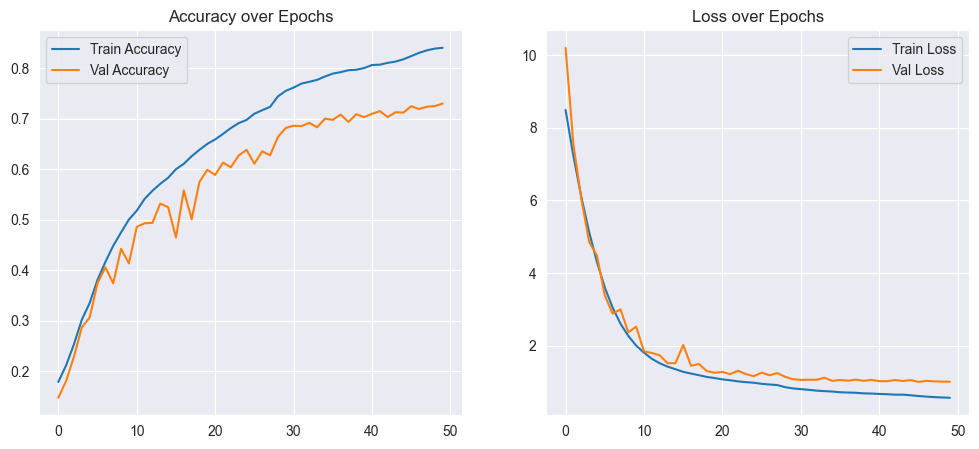

In [10]:
# Plotting Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 105s 490ms/step


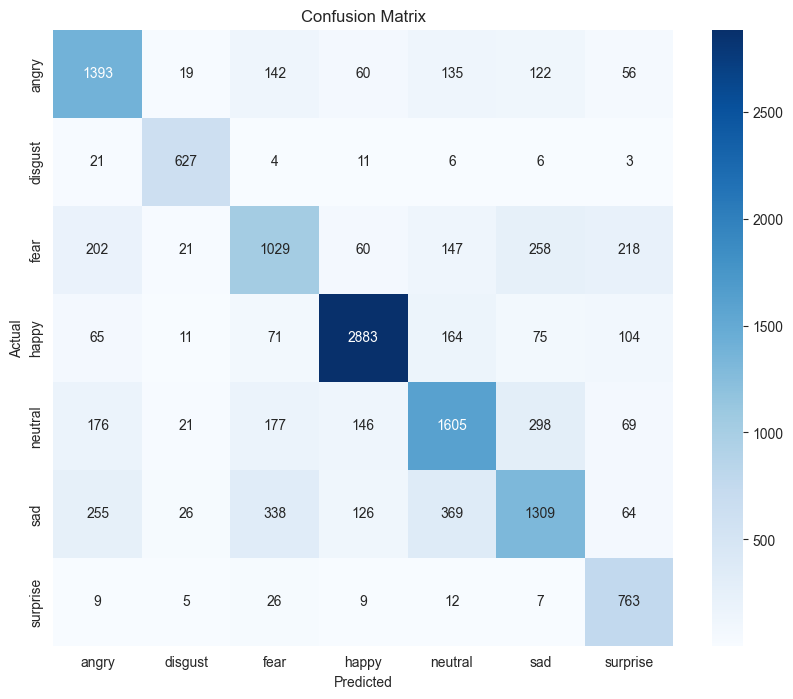

In [11]:
# Predict on validation data (test_data)
y_pred = model.predict(test_data)  # Using test_data (ImageDataGenerator for validation)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test_data (using the flow_from_directory)
y_true_classes = test_data.classes  # Extract true labels from the 'classes' attribute of the generator

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=test_data.class_indices.keys(),  # Using class labels from the generator
            yticklabels=test_data.class_indices.keys())  # Using class labels from the generator
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
from sklearn.metrics import classification_report

# Get predictions
y_pred_prob = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true_classes = test_data.classes  # Extract true labels
class_labels = list(test_data.class_indices.keys())  # Get class names

# Generate Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
              precision    recall  f1-score   support

       angry       0.66      0.72      0.69      1927
     disgust       0.86      0.92      0.89       678
        fear       0.58      0.53      0.55      1935
       happy       0.87      0.85      0.86      3373
     neutral       0.66      0.64      0.65      2492
         sad       0.63      0.53      0.57      2487
    surprise       0.60      0.92      0.72       831

    accuracy                           0.70     13723
   macro avg       0.69      0.73      0.71     13723
weighted avg       0.70      0.70      0.70     13723



In [13]:
model.save("custom_model_v3.keras")

In [4]:
from keras.src.utils import img_to_array
import cv2
# Load the trained model
model = tf.keras.models.load_model("best_model.keras")

# Define the categories
focused_classes = ["Happy", "Neutral", "Surprise"]
unfocused_classes = ["Angry", "Disgust", "Fear", "Sad"]

# Define the image directory
image_folder = "Student_live_captures"  # Folder containing the 50 images

# Emotion class labels (update based on your dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Initialize counters
focused_count = 0
unfocused_count = 0
total_images = 0

# Process each image in the folder
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)

    # Read and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (48, 48))  # Resize to match input shape
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]  # Get the highest probability class

    # Categorize into Focused or Unfocused
    if predicted_class in focused_classes:
        focused_count += 1
    else:
        unfocused_count += 1

    total_images += 1

# Compute the ratio
focused_ratio = focused_count / total_images
unfocused_ratio = unfocused_count / total_images

# Display results
print(f"Total Images: {total_images}")
print(f"Focused Count: {focused_count}")
print(f"Unfocused Count: {unfocused_count}")
print(f"Focused:Unfocused Ratio -> {focused_ratio:.2f} : {unfocused_ratio:.2f}")


NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("custom_model_v3.keras")  # Update with your model path

# Define the image folder
image_folder = "Student_live_captures"  # Folder containing images

# Emotion class labels (update based on dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Get a list of image file names
image_files = os.listdir(image_folder)

# Choose a subset of images to display (adjust number if needed)
num_images_to_display = min(25, len(image_files))  # Display up to 25 images
selected_images = np.random.choice(image_files, num_images_to_display, replace=False)

# Set up plot grid
cols = 5  # Number of columns in the grid
rows = num_images_to_display // cols + (num_images_to_display % cols > 0)  # Auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()  # Flatten in case of excess subplots

# Process and display images
for i, img_name in enumerate(selected_images):
    img_path = os.path.join(image_folder, img_name)

    # Read and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img_resized = cv2.resize(img, (48, 48))  # Resize to match input shape
    img_array = img_resized / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]  # Get highest probability class

    # Display image with prediction
    axes[i].imshow(img_resized, cmap="gray")
    axes[i].set_title(predicted_class, fontsize=12, color="red")
    axes[i].axis("off")  # Hide axes

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Show the plot
plt.tight_layout()
plt.show()